# Generate UMAP GIF for Token Evolution Progression

This notebook is designed to test a potential issue with the Word2Vec alignment algorithm. In the notebook [03_word_decade_figure_generator_2000_2020.ipynb](../word2vec_decade_experiment/03_word_decade_figure_generator_2000_2020.ipynb), words that shouldn't move a lot appear to be moving a lot within the early years (2000-2005). This led to the hypothesis that the alignment for word vectors doesn't work for the earlier years as there is a small amount of data. To see if there is an alignment issue I generated a umap plot of all tokens shared between 2000-2020 and color coded each point based on the year. Conclusion to be discussed at the bottom.

In [1]:
%load_ext autoreload
%autoreload 2

import itertools
from pathlib import Path
import pickle

from adjustText import adjust_text
from gensim.models import Word2Vec
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
import tqdm

from umap.parametric_umap import ParametricUMAP, load_ParametricUMAP

In [2]:
def plot_umap_years(embed_df, years):

    plot_df = (
        embed_df.query(f"year in {years}")
        .groupby("year")
        .apply(lambda x: x.sample(1000, random_state=100))
        .reset_index(drop=True)
    )

    g = (
        p9.ggplot(plot_df, p9.aes(x="umap1", y="umap2", color="year"))
        + p9.geom_point()
        + p9.theme(figure_size=(8, 6))
        + p9.scale_color_brewer(type="qual", palette=3)
    )
    return g

# Load the data

In [3]:
year_cutoff = 2000
latest_year = 2020
aligned_models = dict()
decade_folder = Path("../word2vec_decade_experiment/output")

In [4]:
# Skip 2021 as that model is too small to analyze
# Try again December 2021
word_models = filter(
    lambda x: int(x.stem.split("_")[1]) >= year_cutoff
    and int(x.stem.split("_")[1]) != 2021,
    list((decade_folder / Path("models")).rglob("*model")),
)
word_models = sorted(word_models, key=lambda x: int(x.stem.split("_")[1]), reverse=True)
print(word_models)

[PosixPath('../word2vec_decade_experiment/output/models/word2vec_2020.model'), PosixPath('../word2vec_decade_experiment/output/models/word2vec_2019.model'), PosixPath('../word2vec_decade_experiment/output/models/word2vec_2018.model'), PosixPath('../word2vec_decade_experiment/output/models/word2vec_2017.model'), PosixPath('../word2vec_decade_experiment/output/models/word2vec_2016.model'), PosixPath('../word2vec_decade_experiment/output/models/word2vec_2015.model'), PosixPath('../word2vec_decade_experiment/output/models/word2vec_2014.model'), PosixPath('../word2vec_decade_experiment/output/models/word2vec_2013.model'), PosixPath('../word2vec_decade_experiment/output/models/word2vec_2012.model'), PosixPath('../word2vec_decade_experiment/output/models/word2vec_2011.model'), PosixPath('../word2vec_decade_experiment/output/models/word2vec_2010.model'), PosixPath('../word2vec_decade_experiment/output/models/word2vec_2009.model'), PosixPath('../word2vec_decade_experiment/output/models/word2vec

In [5]:
for model in tqdm.tqdm(word_models):
    year = model.stem.split("_")[1]
    word_model = Word2Vec.load(str(model))

    if year == str(latest_year):
        origin_tokens = sorted(list(set(word_model.wv.vocab.keys())))
        remaining_tokens = origin_tokens

    else:
        tokens = sorted(list(set(word_model.wv.vocab.keys())))
        remaining_tokens = set(origin_tokens) & set(tokens)

    data_records = []

    for tok in remaining_tokens:
        data_entry = dict(
            zip(
                [f"feat_{idx}" for idx in range(len(word_model.wv[tok]))],
                word_model.wv[tok],
            )
        )
        data_entry["token"] = tok
        data_records.append(data_entry)

    aligned_models[year] = pd.DataFrame.from_records(data_records)

100%|██████████| 21/21 [10:03<00:00, 28.72s/it]


# Train the UMAP Model without Alignment

## Train Model on Un-Aligned Matricies

In [6]:
origin_df = aligned_models["2000"]
word_vectors = list(
    map(
        lambda x: x.query(f"token in {origin_df.token.tolist()}")
        .sort_values("token")
        .set_index("token")
        .values,
        aligned_models.values(),
    )
)

In [7]:
word_models_stacked = np.vstack(word_vectors)
file_name = "output/2000_2020_umap_model_no_alignment"

In [8]:
if not Path(file_name).exists():
    model = ParametricUMAP(
        verbose=False,
        metric="cosine",
        random_state=100,
        low_memory=True,
        n_neighbors=25,
        min_dist=0.0,
    )
    embedding = model.fit_transform(word_models_stacked)
    model.save(file_name)
else:
    model = load_ParametricUMAP(str(file_name))
    model.verbose = False
    embedding = model.transform(word_models_stacked)

Pickle of ParametricUMAP model loaded from output/2000_2020_umap_model_no_alignment/model.pkl
Keras encoder model loaded from output/2000_2020_umap_model_no_alignment/encoder
Keras full model loaded from output/2000_2020_umap_model_no_alignment/parametric_model


In [9]:
unaligned_embedding_model_df = pd.DataFrame(
    {
        "umap1": embedding[:, 0],
        "umap2": embedding[:, 1],
        "year": itertools.chain(
            *list(
                map(
                    lambda x: aligned_models[x]
                    .query(f"token in {origin_df.token.tolist()}")
                    .sort_values("token")
                    .set_index("token")
                    .assign(year=x)
                    .year.tolist(),
                    aligned_models.keys(),
                )
            )
        ),
        "token": itertools.chain(
            *list(
                map(
                    lambda x: x.query(f"token in {origin_df.token.tolist()}")
                    .sort_values("token")
                    .set_index("token")
                    .index.tolist(),
                    aligned_models.values(),
                )
            )
        ),
    }
)
unaligned_embedding_model_df.sample(10, random_state=100)

,umap1,umap2,year,token
527312,-21.683943,42.370956,2000,quebec
324037,-6.274336,25.512066,2009,pyuria
425081,-12.822536,42.716583,2005,unfavorable
67030,-0.839981,1.117476,2018,fallot
119669,0.671409,2.955484,2016,dangerous
420939,-12.605099,42.513779,2005,queen
491418,-23.033108,48.485291,2001,creb
410770,-12.854399,42.854160,2005,dilution
61268,-3.505891,-2.335627,2018,blnk
416269,-13.323845,42.732666,2005,liposome


## Plot Early Years vs Later Years

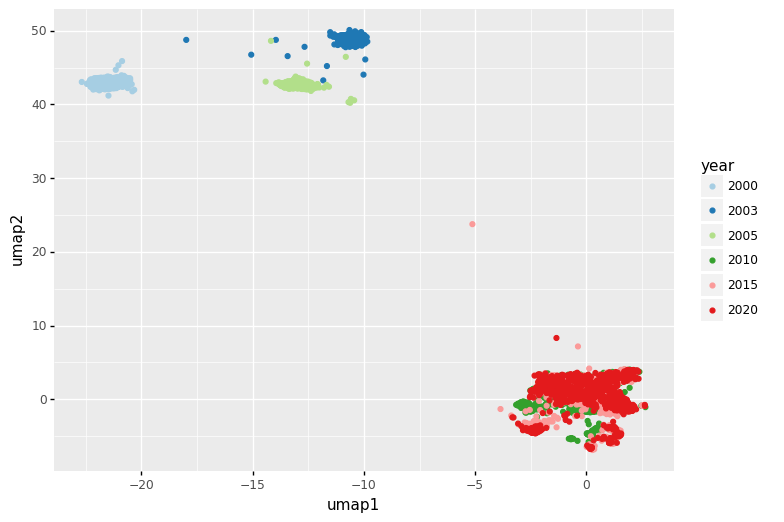

<ggplot: (-9223363283224990534)>

In [10]:
years_to_test = ["2000", "2003", "2005", "2010", "2015", "2020"]
plot_umap_years(unaligned_embedding_model_df, years_to_test)

## Plot Across the Years

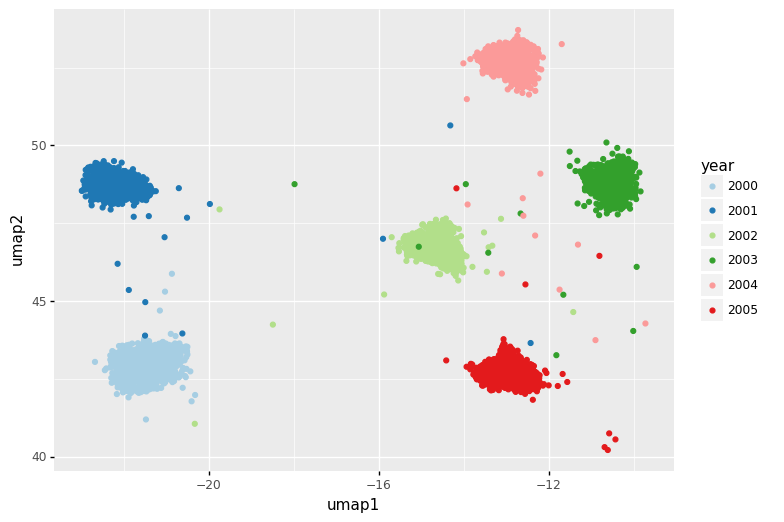

<ggplot: (8753630987030)>

In [11]:
years_to_test = ["2000", "2001", "2002", "2003", "2004", "2005"]
plot_umap_years(unaligned_embedding_model_df, years_to_test)

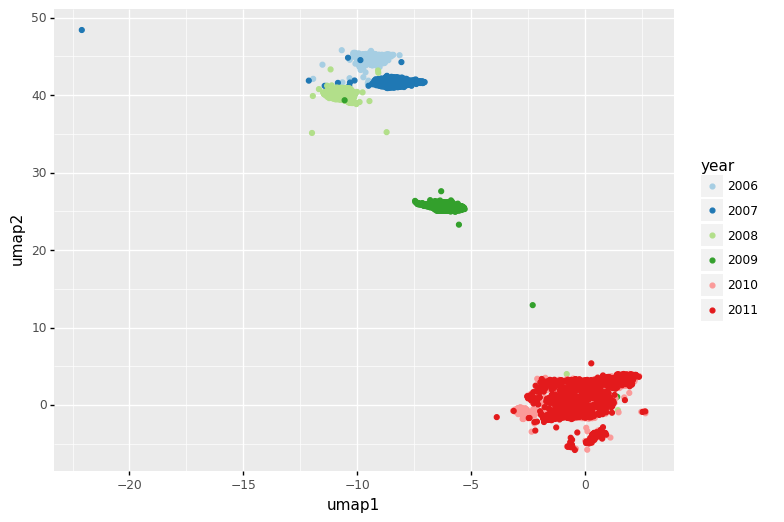

<ggplot: (8753630687485)>

In [12]:
years_to_test = ["2006", "2007", "2008", "2009", "2010", "2011"]
plot_umap_years(unaligned_embedding_model_df, years_to_test)

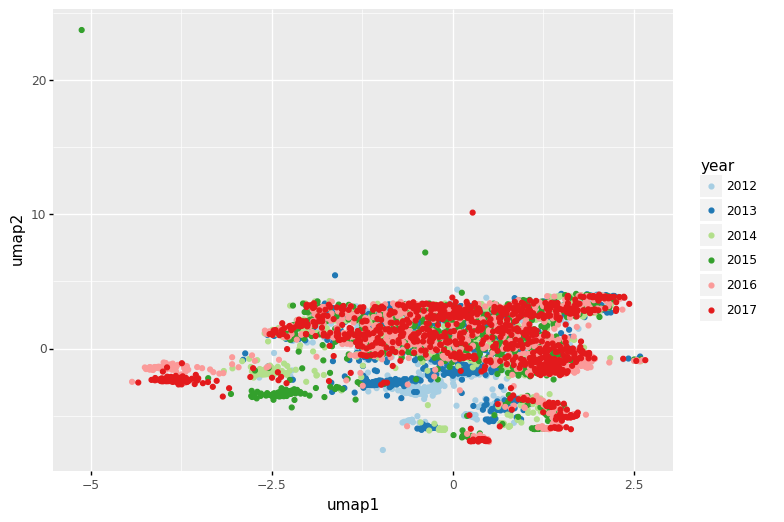

<ggplot: (-9223363283223866708)>

In [13]:
years_to_test = ["2012", "2013", "2014", "2015", "2016", "2017"]
plot_umap_years(unaligned_embedding_model_df, years_to_test)

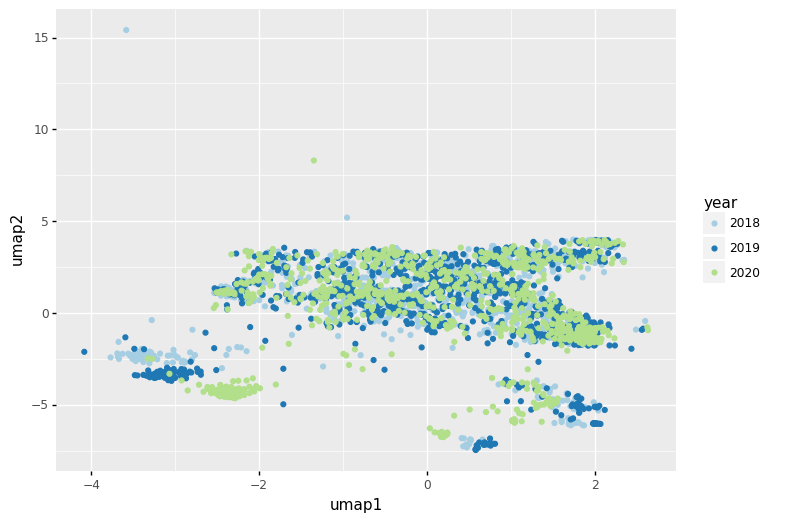

<ggplot: (-9223363283223801235)>

In [14]:
years_to_test = ["2018", "2019", "2020"]
plot_umap_years(unaligned_embedding_model_df, years_to_test)

# Train UMAP with Alignment

## Train Model on Aligned Matricies

In [15]:
aligned_models = pickle.load(
    open(str(decade_folder / Path("aligned_word_vectors_2000_2020.pkl")), "rb")
)

In [16]:
origin_df = aligned_models["2000"]
word_vectors = list(
    map(
        lambda x: x.query(f"token in {origin_df.token.tolist()}")
        .sort_values("token")
        .set_index("token")
        .values,
        aligned_models.values(),
    )
)

In [17]:
word_models_stacked = np.vstack(word_vectors)
file_name = "output/2000_2020_umap_model_with_alignment"

In [18]:
if not Path(file_name).exists():
    model = ParametricUMAP(
        verbose=False,
        metric="cosine",
        random_state=100,
        low_memory=True,
        n_neighbors=25,
        min_dist=0.0,
    )
    embedding = model.fit_transform(word_models_stacked)
    model.save(file_name)
else:
    model = load_ParametricUMAP(str(file_name))
    model.verbose = False
    embedding = model.transform(word_models_stacked)

Pickle of ParametricUMAP model loaded from output/2000_2020_umap_model_with_alignment/model.pkl
Keras encoder model loaded from output/2000_2020_umap_model_with_alignment/encoder
Keras full model loaded from output/2000_2020_umap_model_with_alignment/parametric_model


In [19]:
aligned_embedding_model_df = pd.DataFrame(
    {
        "umap1": embedding[:, 0],
        "umap2": embedding[:, 1],
        "year": itertools.chain(
            *list(
                map(
                    lambda x: aligned_models[x]
                    .query(f"token in {origin_df.token.tolist()}")
                    .sort_values("token")
                    .set_index("token")
                    .assign(year=x)
                    .year.tolist(),
                    aligned_models.keys(),
                )
            )
        ),
        "token": itertools.chain(
            *list(
                map(
                    lambda x: x.query(f"token in {origin_df.token.tolist()}")
                    .sort_values("token")
                    .set_index("token")
                    .index.tolist(),
                    aligned_models.values(),
                )
            )
        ),
    }
)
aligned_embedding_model_df.sample(10, random_state=100)

,umap1,umap2,year,token
527312,-7.090622,-4.010212,2000,quebec
324037,-6.831904,-2.474190,2009,pyuria
425081,-6.139398,-5.280954,2005,unfavorable
67030,3.056031,0.752165,2018,fallot
119669,-0.160202,-6.069229,2016,dangerous
420939,-5.434992,-6.310815,2005,queen
491418,-4.452618,-2.306749,2001,creb
410770,-0.880229,-2.093141,2005,dilution
61268,-6.238903,1.159619,2018,blnk
416269,-5.805717,-3.455616,2005,liposome


## Plot the early years against the later years

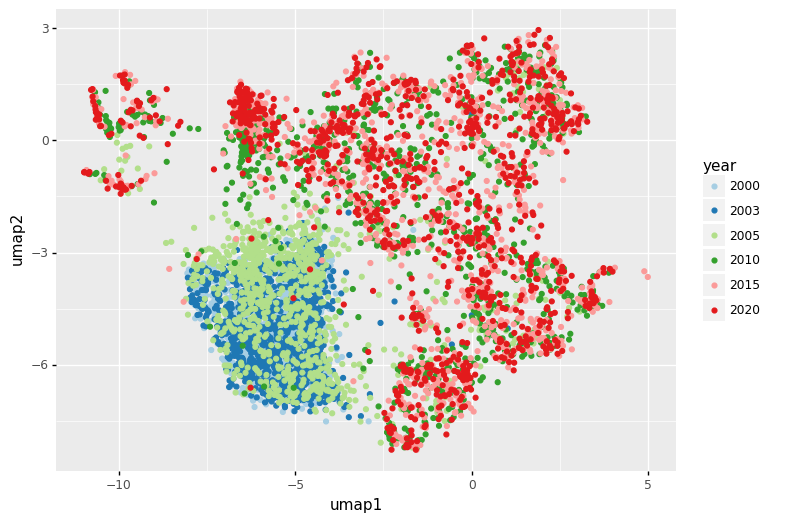

<ggplot: (-9223363283009660591)>

In [20]:
years_to_test = ["2000", "2003", "2005", "2010", "2015", "2020"]
plot_umap_years(aligned_embedding_model_df, years_to_test)

## Plot each Year Along the Axes

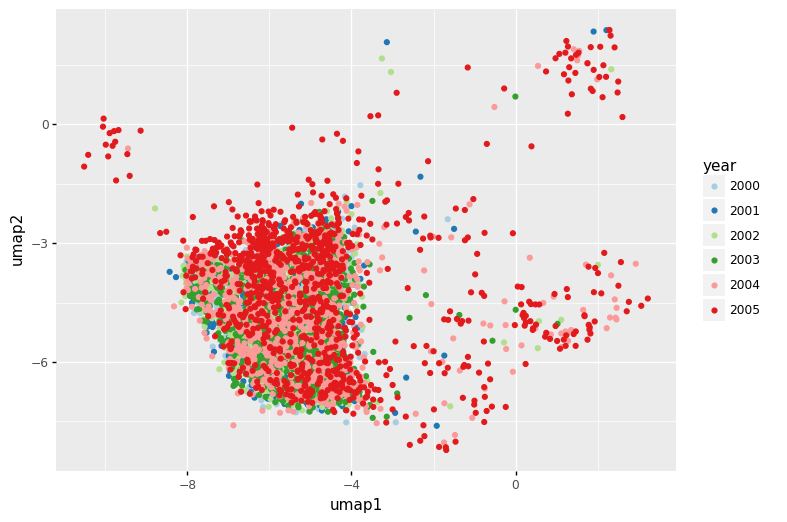

<ggplot: (8753822015303)>

In [21]:
years_to_test = ["2000", "2001", "2002", "2003", "2004", "2005"]
plot_umap_years(aligned_embedding_model_df, years_to_test)

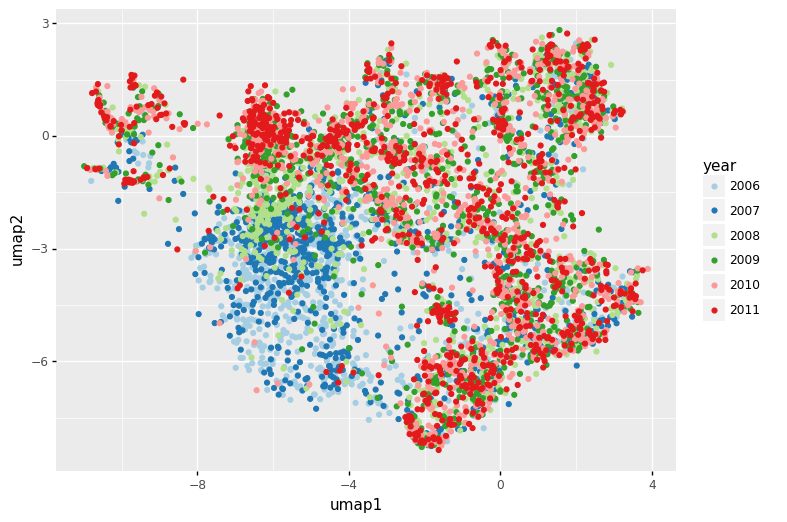

<ggplot: (8753844768744)>

In [22]:
years_to_test = ["2006", "2007", "2008", "2009", "2010", "2011"]
plot_umap_years(aligned_embedding_model_df, years_to_test)

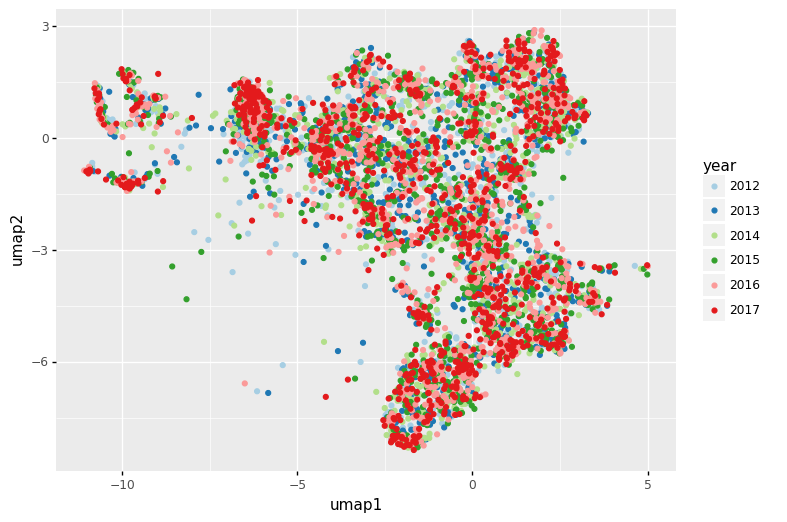

<ggplot: (-9223363283009927150)>

In [23]:
years_to_test = ["2012", "2013", "2014", "2015", "2016", "2017"]
plot_umap_years(aligned_embedding_model_df, years_to_test)

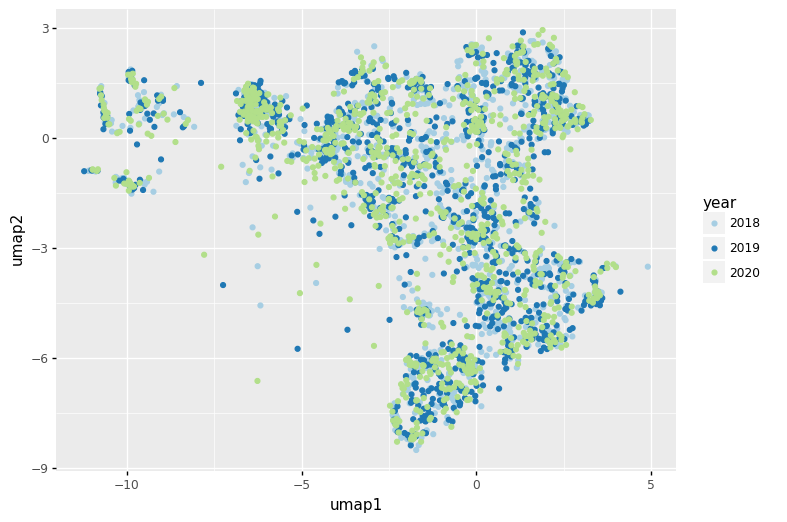

<ggplot: (-9223363283009968110)>

In [24]:
years_to_test = ["2018", "2019", "2020", "2021"]
plot_umap_years(aligned_embedding_model_df, years_to_test)

# 'Are' use case for aligned and unaligned

In [25]:
plot_df = (
    aligned_embedding_model_df.query("token=='are'")
    .assign(label="align")
    .append(unaligned_embedding_model_df.query("token=='are'").assign(label="unalign"))
)
plot_df.sample(10, random_state=100)

,umap1,umap2,year,token,label
170924,1.858579,3.144267,2014,are,unalign
143346,-1.811338,-6.545394,2015,are,align
170924,-1.735574,-6.538186,2014,are,align
449612,-11.256863,48.083942,2003,are,unalign
4161,1.948296,3.234072,2020,are,unalign
4161,-1.764737,-6.614325,2020,are,align
509490,-3.730095,-6.500844,2000,are,align
509490,-19.518545,43.912376,2000,are,unalign
383624,-10.882565,43.972187,2006,are,unalign
406858,-12.336335,48.505226,2005,are,unalign


## Plot both versions

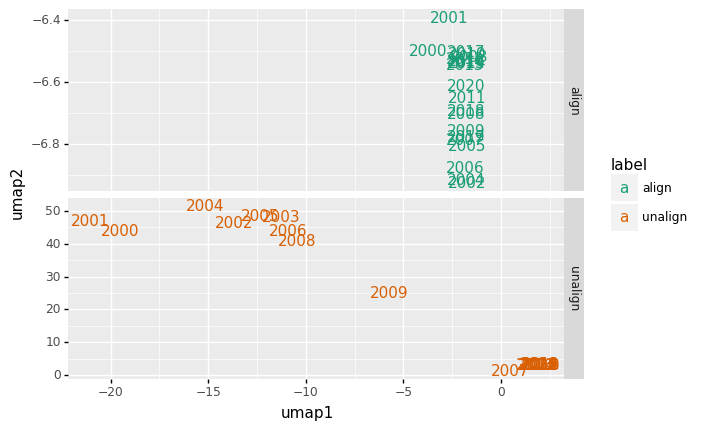

<ggplot: (8753845642588)>


In [26]:
g = (
    p9.ggplot(plot_df, p9.aes(x="umap1", y="umap2", color="label", label="year"))
    + p9.geom_text()
    + p9.scale_color_brewer(type="qual", palette=2)
    + p9.facet_grid("label ~ .", scales="free")
)
print(g)

# 'interleukin-18' use case for aligned and unaligned

In [27]:
plot_df = (
    aligned_embedding_model_df.query("token=='interleukin-18'")
    .assign(label="align")
    .append(
        unaligned_embedding_model_df.query("token=='interleukin-18'").assign(
            label="unalign"
        )
    )
)
plot_df.sample(10, random_state=100)

,umap1,umap2,year,token,label
181149,0.888058,-1.809444,2014,interleukin-18,unalign
153572,-3.902036,0.850817,2015,interleukin-18,align
181149,-4.012433,0.658087,2014,interleukin-18,align
457089,-10.626704,48.766006,2003,interleukin-18,unalign
14678,2.020386,-1.501935,2020,interleukin-18,unalign
14678,-4.029090,0.595272,2020,interleukin-18,align
520007,-4.525804,-3.254931,2000,interleukin-18,align
520007,-22.159437,43.151814,2000,interleukin-18,unalign
392401,-9.663197,45.171082,2006,interleukin-18,unalign
415283,-13.640711,46.571095,2005,interleukin-18,unalign


## Plot both versions

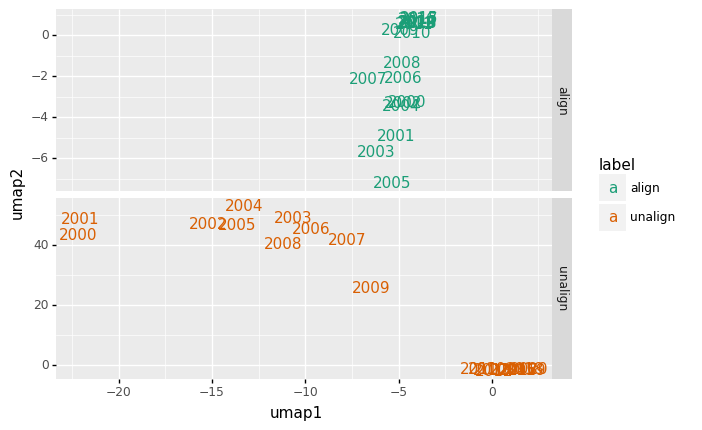

<ggplot: (-9223363283032184432)>


In [28]:
g = (
    p9.ggplot(plot_df, p9.aes(x="umap1", y="umap2", color="label", label="year"))
    + p9.geom_text()
    + p9.scale_color_brewer(type="qual", palette=2)
    + p9.facet_grid("label ~ .", scales="free")
)
print(g)

# Conclusions and Take Home Points

1. The alignment process seems to be working as the scale is a lot more reasonable once aligned to 2020.
2. The shift scale for words is more reasonable after alignment, which provides indication that alignment does work in the grand scheme of this project; however, pre-2005 may still be an issue.
3. The word are actually doesn't move a lot when compared to the unaligned version, which is a great negative control for this experiment.
4. The gene interleukin-18 underwent a larger change than 'are' which makes sense as this gene was discovered to be an indicator for inflammation for certain diseases.